In [512]:
import cv2 as cv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from scipy import ndimage as ndi


In [506]:
def show_images(images, titles=None):
    # This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


def iterative_threshold(image):
    # Set initial threshold value
    thresh = np.mean(image)

    # Set initial threshold difference value
    diff = 10

    # Loop until threshold difference falls below 1
    while diff > 1:
        # Threshold the image
        _, thresh_img = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)

        # Calculate the mean pixel values on either side of the threshold
        mean_low = np.mean(image[thresh_img == 0])
        mean_high = np.mean(image[thresh_img == 255])

        # Update the threshold value
        new_thresh = (mean_low + mean_high) / 2
        diff = abs(thresh - new_thresh)
        thresh = new_thresh

    # Return the thresholded image
    return thresh_img


def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)

    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')


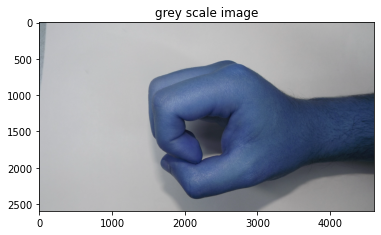

In [507]:
# Read image
img = cv.imread('../Dataset_0-5/men/0/0_men (2).JPG')
show_images(images=[img],titles=["grey scale image"])


## Solution using HSV (Worst)

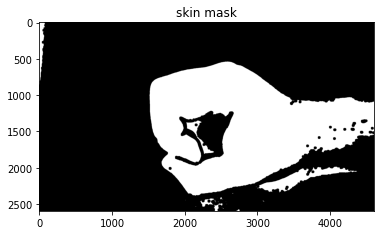

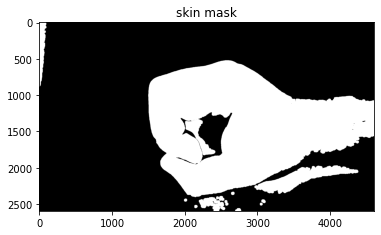

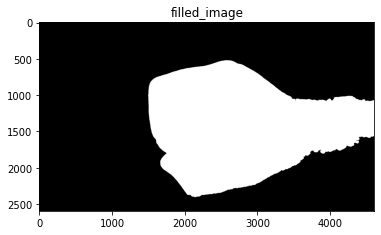

In [508]:
lower = np.array([0, 20, 70], dtype=np.uint8)
upper = np.array([50, 255, 255], dtype=np.uint8)
converted = cv.cvtColor(img, cv.COLOR_BGR2HSV)
skinMask = cv.inRange(converted, lower, upper)
# apply a series of erosions and dilations to the mask
# using an elliptical kernel
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20, 20))
skinMask = cv.erode(skinMask, kernel, iterations=2)
show_images(images=[skinMask], titles=["skin mask"])
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20, 20))
skinMask = cv.dilate(skinMask, kernel, iterations=2)

show_images(images=[skinMask],titles=["skin mask"])

# Find the contours in the binary image
# binary_ycrcb_image_inv = cv.bitwise_not(binary_ycrcb_image)
binary_ycrcb_image_inv = skinMask.copy()

contours, hierarchy = cv.findContours(
    binary_ycrcb_image_inv, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Get the contour with the largest area
largest_contour = max(contours, key=cv.contourArea)

# Create a blank image to draw and fill the contours
largest_contour_image = np.zeros_like(img)
# Draw the largest contour on the image
cv.drawContours(largest_contour_image, [largest_contour], 0, (255, 255, 255), -1)


show_images([largest_contour_image], ["filled_image"])


## Solution using ycrcb (2nd best)

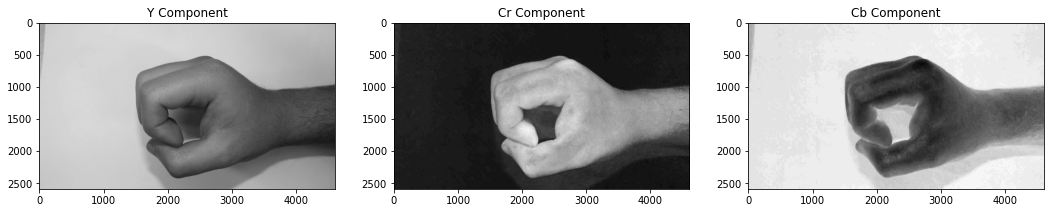

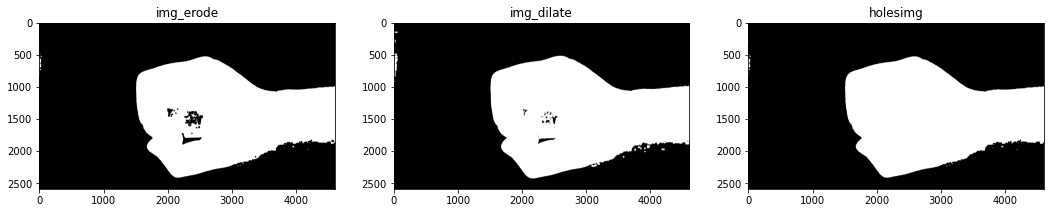

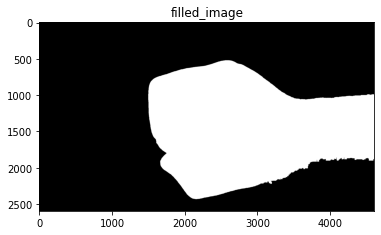

In [509]:
# Convert the input image to YCrCb color space
ycrcb_image = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)

# Define the lower and upper bounds of the skin color in YCrCb color space
lower_skin = np.array([0, 133, 77])
upper_skin = np.array([255, 180, 150])

# Apply the color segmentation using cv2.inRange()
binary_ycrcb_image = cv.inRange(ycrcb_image, lower_skin, upper_skin)

# show_images([binary_ycrcb_image], ["threshold ycrcb"])

# Extract the individual color components
y, cr, cb = cv.split(ycrcb_image)

# Show the individual color components
show_images([y, cr, cb], ['Y Component', 'Cr Component', 'Cb Component'])

kernel = np.ones((20, 20), np.uint8)

img_erode = cv.erode(binary_ycrcb_image, kernel, iterations=1)

holesimg = ndi.binary_fill_holes(img_erode).astype(int)

kernel = np.ones((20, 20), np.uint8)

img_dilate = cv.dilate(img_erode, kernel, iterations=1)
# # Perform morphological closing to fill small holes
# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
# closed_img = cv.morphologyEx(binary_ycrcb_image, cv.MORPH_CLOSE, kernel)

# # Perform morphological opening to remove large holes
# kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20, 20))
# opened_img = cv.morphologyEx(closed_img, cv.MORPH_OPEN, kernel)

show_images([img_erode, img_dilate, holesimg], ["img_erode", "img_dilate", "holesimg"])


# Find the contours in the binary image
# binary_ycrcb_image_inv = cv.bitwise_not(binary_ycrcb_image)
binary_ycrcb_image_inv = img_dilate.copy()

contours, hierarchy = cv.findContours(
    binary_ycrcb_image_inv, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Get the contour with the largest area
largest_contour = max(contours, key=cv.contourArea)

# Create a blank image to draw and fill the contours
largest_contour_image_ycrcb = np.zeros_like(img)
# Draw the largest contour on the image
cv.drawContours(largest_contour_image, [
                largest_contour], 0, (255, 255, 255), -1)


show_images([largest_contour_image], ["filled_image"])


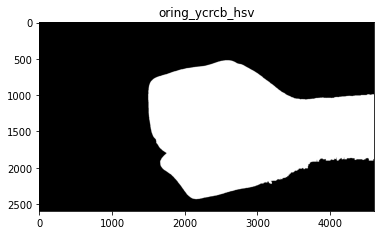

In [510]:
oring_ycrcb_hsv = cv.bitwise_or(largest_contour_image, largest_contour_image_ycrcb)
show_images([oring_ycrcb_hsv], ["oring_ycrcb_hsv"])


## Solution using histogram equalization (Best)

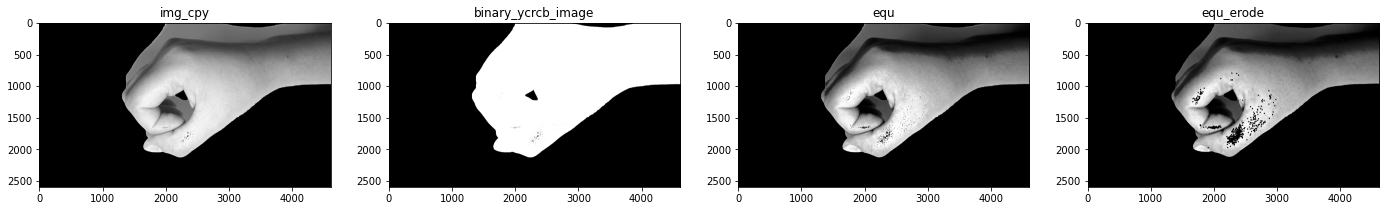

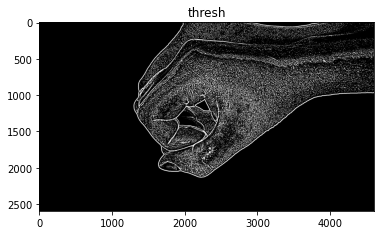

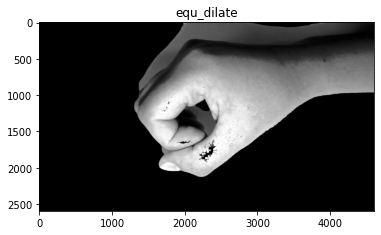

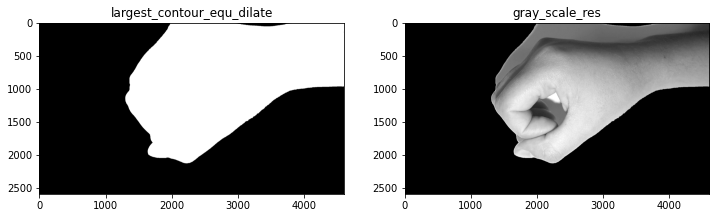

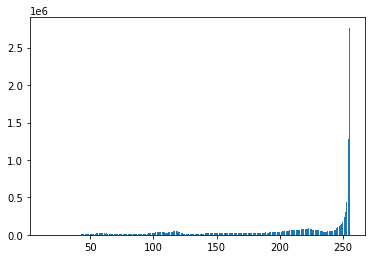

In [533]:
img = cv.imread('../Dataset_0-5/Women/0/0_woman (50).JPG')


# Convert the input image to YCrCb color space
ycrcb_image = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)

# Define the lower and upper bounds of the skin color in YCrCb color space
lower_skin = np.array((0, 133, 77))
upper_skin = np.array((255, 173, 127))

# Apply the color segmentation using cv2.inRange()
binary_ycrcb_image = cv.inRange(ycrcb_image, lower_skin, upper_skin)

img_cpy_original = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_cpy = img_cpy_original.copy()
img_cpy[binary_ycrcb_image == 0] = 0


kernel = np.ones((3, 3), np.uint8)

img_cpy_erode = cv.erode(img_cpy, kernel, iterations=2)

# Perform histogram equalization
equ = cv.equalizeHist(img_cpy_erode)

thresh = cv2.adaptiveThreshold(
    equ, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 27, 2)

kernel = np.ones((5, 5), np.uint8)

equ_erode = cv.erode(equ, kernel, iterations=3)

blur = cv2.GaussianBlur(equ_erode, (11, 11), 0)

kernel = np.ones((5, 5), np.uint8)

equ_dilate = cv.dilate(blur, kernel, iterations=4)

show_images([img_cpy, binary_ycrcb_image, equ, equ_erode], ["img_cpy", "binary_ycrcb_image", "equ", "equ_erode"])

show_images([thresh], ["thresh"])
show_images([equ_dilate],["equ_dilate"])


contours, hierarchy = cv.findContours(
    equ_dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Get the contour with the largest area
largest_contour = max(contours, key=cv.contourArea)

# Create a blank image to draw and fill the contours
largest_contour_equ_dilate = np.zeros_like(img_cpy)
# Draw the largest contour on the image
cv.drawContours(largest_contour_equ_dilate, [
                largest_contour], 0, (255, 255), -1)

gray_scale_res = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_scale_res[largest_contour_equ_dilate == 0] = 0
show_images([largest_contour_equ_dilate, gray_scale_res],
            ["largest_contour_equ_dilate", "gray_scale_res"])


showHist(img_cpy_original)
